# HW4P2: Attention-based Speech Recognition

Welcome to the final assignment in 11785. In this HW, you will work on building a speech recognition system with attention. <br> <br>

HW Writeup: https://piazza.com/class_profile/get_resource/l37uyxe87cq5xn/lam1lcjjj0314e <br>
Kaggle competition link: https://www.kaggle.com/competitions/11-785-f22-hw4p2/ <br>
LAS Paper: https://arxiv.org/pdf/1508.01211.pdf <br>
Attention is all you need:https://arxiv.org/pdf/1706.03762.pdf

# Initial Set-up

In [ ]:
!nvidia-smi

Fri Dec 16 11:30:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    52W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Install some required libraries
# Feel free to add more if you want
!pip install -q python-levenshtein torchsummaryX wandb

     |████████████████████████████████| 1.9 MB 39.8 MB/s 
     |████████████████████████████████| 174 kB 89.7 MB/s 
     |████████████████████████████████| 2.2 MB 85.4 MB/s 
     |████████████████████████████████| 173 kB 94.8 MB/s 
     |████████████████████████████████| 182 kB 94.6 MB/s 
     |████████████████████████████████| 62 kB 1.6 MB/s 
     |████████████████████████████████| 168 kB 95.3 MB/s 
     |████████████████████████████████| 168 kB 97.0 MB/s 
     |████████████████████████████████| 166 kB 102.3 MB/s 
     |████████████████████████████████| 166 kB 98.1 MB/s 
     |████████████████████████████████| 162 kB 92.6 MB/s 
     |████████████████████████████████| 162 kB 98.2 MB/s 
     |████████████████████████████████| 158 kB 77.6 MB/s 
     |████████████████████████████████| 157 kB 105.2 MB/s 
     |████████████████████████████████| 157 kB 104.6 MB/s 
     |████████████████████████████████| 157 kB 103.3 MB/s 
     |████████████████████████████████| 157 kB 79.7 MB/s 
     |██████

# Import

In [ ]:
import os
import pandas as pd
import numpy as np
import Levenshtein

import torch
import torchaudio

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import gc
from torchsummaryX import summary
import wandb
from glob import glob

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", DEVICE)

Device:  cuda


# Config

In [ ]:
# Global config dict. Feel free to add or change if you want.
config = {
    'batch_size': 96,
    'epochs': 100,
    'lr': 1e-5 # initially 1e-4
}

# Kaggle Data

In [ ]:
# Download the data
!kaggle competitions download -c 11-785-f22-hw4p2
!mkdir '/content/data'

!unzip -qo '11-785-f22-hw4p2.zip' -d '/content/data'

100% 2.08G/2.09G [01:40<00:00, 23.2MB/s]
100% 2.09G/2.09G [01:40<00:00, 22.4MB/s]


# Dataset Class

In [ ]:
# These are the various characters in the transcripts of the datasetW
VOCAB = ['<sos>',   
         'A',   'B',    'C',    'D',    
         'E',   'F',    'G',    'H',    
         'I',   'J',    'K',    'L',       
         'M',   'N',    'O',    'P',    
         'Q',   'R',    'S',    'T', 
         'U',   'V',    'W',    'X', 
         'Y',   'Z',    "'",    ' ', 
         '<eos>']

VOCAB_MAP = {VOCAB[i]:i for i in range(0, len(VOCAB))}

SOS_TOKEN = VOCAB_MAP["<sos>"]
EOS_TOKEN = VOCAB_MAP["<eos>"]

In [ ]:
train_transforms = torch.nn.Sequential(
    torchaudio.transforms.FrequencyMasking(freq_mask_param=5),
    torchaudio.transforms.TimeMasking(time_mask_param=50)
)

In [ ]:
class AudioDataset(torch.utils.data.Dataset):
    def __init__(self, data_path, partition, train=False): 
        self.data_path = data_path
        # Load the directory and all files in them
        if partition == "train-clean-100":
            self.mfcc_dir = os.path.join(self.data_path, "train-clean-100", "mfcc")
            self.transcript_dir = os.path.join(self.data_path, "train-clean-100", "transcript", "raw")
        else:
            self.mfcc_dir = os.path.join(self.data_path, "dev-clean", "mfcc")
            self.transcript_dir = os.path.join(self.data_path, "dev-clean", "transcript", "raw")

        self.mfcc_files = sorted(os.listdir(self.mfcc_dir))
        self.transcript_files = sorted(os.listdir(self.transcript_dir))
        
        assert len(self.mfcc_files) == len(self.transcript_files)

        self.VOCAB_MAP = VOCAB_MAP
        self.train = train

        self.mfccs, self.transcripts = [], []
        eps = 1e-30
        
        for i in range(0, len(self.mfcc_files)):
            mfcc = np.load(os.path.join(self.mfcc_dir, self.mfcc_files[i]))
            mfcc_mean = np.mean(mfcc, axis=0)
            mfcc_mean = np.tile(mfcc_mean, (mfcc.shape[0], 1))
            
            mfcc = mfcc - mfcc_mean
            
            mfcc_stdev = np.std(mfcc, axis=0)
            mfcc_stdev = np.tile(mfcc_stdev, (mfcc.shape[0], 1))
            
            mfcc = mfcc / (mfcc_stdev + eps)
            transcript = np.load(os.path.join(self.transcript_dir, self.transcript_files[i]))
            
            self.mfccs.append(mfcc)
            self.transcripts.append(transcript)
        
        self.mfccs = np.array(self.mfccs, dtype=object)
        self.transcripts = np.array([[self.VOCAB_MAP[phoneme] for phoneme in transcript] for transcript in self.transcripts], dtype=object)
        self.length = len(self.mfccs)

    def __len__(self):
        return self.length

    def __getitem__(self, ind):
        mfcc = self.mfccs[ind]
        transcript = self.transcripts[ind]
        return torch.FloatTensor(mfcc), torch.LongTensor(transcript)

    def collate_fn(self, batch):
        '''
        1.  Extract the features and labels from 'batch'
        2.  We will additionally need to pad both features and labels,
            look at pytorch's docs for pad_sequence
        3.  This is a good place to perform transforms, if you so wish. 
            Performing them on batches will speed the process up a bit.
        4.  Return batch of features, labels, lenghts of features, 
            and lengths of labels.
        '''
        batch_mfcc = [mfcc for mfcc, _ in batch]
        if self.train:
            batch_mfcc = [torch.squeeze(train_transforms(torch.tensor(mfcc[np.newaxis, :]).permute(0, 2, 1)).permute(0, 2, 1), dim=0) for mfcc in batch_mfcc]
        
        batch_transcript = [phoneme for _, phoneme in batch]
        batch_mfcc_pad = torch.nn.utils.rnn.pad_sequence(batch_mfcc, batch_first=True)
        lengths_mfcc = [mfcc.shape[0] for mfcc in batch_mfcc] 

        batch_transcript_pad = torch.nn.utils.rnn.pad_sequence(batch_transcript, batch_first=True)
        lengths_transcript = [transcript.shape[0] for transcript in batch_transcript]

        return batch_mfcc_pad, batch_transcript_pad, torch.tensor(lengths_mfcc), torch.tensor(lengths_transcript)


In [ ]:
train_data = AudioDataset(os.path.join(os.getcwd(), "data", "hw4p2"), partition="train-clean-100", train=True)
val_data = AudioDataset(os.path.join(os.getcwd(), "data", "hw4p2"), partition="validation")

In [ ]:
class AudioDatasetTest(torch.utils.data.Dataset):
    def __init__(self, data_path): 
        self.data_path = data_path
        self.mfcc_dir = os.path.join(self.data_path, "test-clean", "mfcc")
        self.mfcc_files = sorted(os.listdir(self.mfcc_dir))

        self.mfccs = []
        eps = 1e-30
        
        for i in range(0, len(self.mfcc_files)):
            mfcc = np.load(os.path.join(self.mfcc_dir, self.mfcc_files[i]))
            mfcc_mean = np.mean(mfcc, axis=0)
            mfcc_mean = np.tile(mfcc_mean, (mfcc.shape[0], 1))
            mfcc = mfcc - mfcc_mean
            mfcc_stdev = np.std(mfcc, axis=0)
            mfcc_stdev = np.tile(mfcc_stdev, (mfcc.shape[0], 1))
            mfcc = mfcc / (mfcc_stdev + eps)
            self.mfccs.append(mfcc)

        self.mfccs = np.array(self.mfccs, dtype=object)
        self.length = len(self.mfccs)

    def __len__(self):
        return self.length

    def __getitem__(self, ind):
        mfcc = self.mfccs[ind]
        return torch.FloatTensor(mfcc)

    def collate_fn(self, batch):
        batch_mfcc = batch
        batch_mfcc_pad = torch.nn.utils.rnn.pad_sequence(batch_mfcc, batch_first=True)
        lengths_mfcc = [mfcc.shape[0] for mfcc in batch_mfcc] 
        return batch_mfcc_pad, torch.tensor(lengths_mfcc)


In [ ]:
test_data = AudioDatasetTest(os.path.join(os.getcwd(), "data", "hw4p2"))

# Dataset and Dataloaders

In [ ]:
# get me RAMMM!!!! 
import gc 
gc.collect()

77

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, num_workers=2,
                                           batch_size=config["batch_size"], pin_memory= True, collate_fn=train_data.collate_fn,
                                           shuffle= True)
val_loader = torch.utils.data.DataLoader(val_data, num_workers=2,
                                           batch_size=config["batch_size"], pin_memory= True, collate_fn=val_data.collate_fn,
                                           shuffle= False)
test_loader = torch.utils.data.DataLoader(test_data, num_workers=2,
                                           batch_size=config["batch_size"], pin_memory= True, collate_fn=test_data.collate_fn,
                                           shuffle= False)

print("Batch size: ", config["batch_size"])
print("Train dataset samples = {}, batches = {}".format(train_data.__len__(), len(train_loader)))
print("Val dataset samples = {}, batches = {}".format(val_data.__len__(), len(val_loader)))
print("Test dataset samples = {}, batches = {}".format(test_data.__len__(), len(test_loader)))

Batch size:  96
Train dataset samples = 28539, batches = 298
Val dataset samples = 2703, batches = 29
Test dataset samples = 2620, batches = 28


In [ ]:
# sanity check
for data in train_loader:
    x, y, lx, ly = data
    print(x.shape, y.shape, lx.shape, ly.shape)
    break

<ipython-input-11-95cd4d6fa691>:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_mfcc = [torch.squeeze(train_transforms(torch.tensor(mfcc[np.newaxis, :]).permute(0, 2, 1)).permute(0, 2, 1), dim=0) for mfcc in batch_mfcc]
<ipython-input-11-95cd4d6fa691>:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_mfcc = [torch.squeeze(train_transforms(torch.tensor(mfcc[np.newaxis, :]).permute(0, 2, 1)).permute(0, 2, 1), dim=0) for mfcc in batch_mfcc]


torch.Size([96, 1667, 15]) torch.Size([96, 340]) torch.Size([96]) torch.Size([96])


# Model

In this section you will be building the LAS model from scratch. Before starting to code, please read the writeup, paper and understand the following parts completely.<br>
- Pyramidal Bi-LSTM 
- Listener
- Attention
- Speller

After getting a good grasp of the workings of these modules, start coding. Follow the TODOs carefully. We will also be adding some extra features to the attention mechanism like keys and values which are not originally present in LAS. So we will be creating a hybrid network based on LAS and Attention is All You Need.


## Encoder

### Pyramidal Bi-LSTM

In [ ]:
from torch.autograd import Variable

class LockedDropout(torch.nn.Module):
    def __init__(self, p=0.5):
        super().__init__()
        self.dropout = p

    def forward(self, x, ):
        if not self.training or not self.dropout:
            return x
        m = x.data.new(1, x.size(1), x.size(2)).bernoulli_(1 - self.dropout)
        mask = Variable(m, requires_grad=False) / (1 - self.dropout)
        mask = mask.expand_as(x)
        return mask * x

class pBLSTM(torch.nn.Module):
    '''
    Pyramidal BiLSTM
    '''
    def __init__(self, input_size, hidden_size):
        super(pBLSTM, self).__init__()
        self.blstm = torch.nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size, 
            num_layers=1, 
            bidirectional=True
        )
        self.ldrop = LockedDropout(p=0.4)

    def forward(self, x_packed): # x_packed is a PackedSequence
        x_unpacked, xlens = torch.nn.utils.rnn.pad_packed_sequence(x_packed, batch_first=True)
        x_unpacked = self.ldrop(x_unpacked)
        x, xlens = self.trunc_reshape(x_unpacked, xlens)
        x_packed = torch.nn.utils.rnn.pack_padded_sequence(x, xlens, batch_first=True, enforce_sorted=False)
        out, _ = self.blstm(x_packed)
        return out

    def trunc_reshape(self, x, xlens):
        T = x.size(1)
        if T % 2:
            x = x[:, :-1, :]
        x = x.reshape(x.size(0), T//2, x.size(2) * 2)
        xlens = torch.div(xlens, 2, rounding_mode="floor")
        return x, xlens


### Listener

In [ ]:
class Listener(torch.nn.Module):
    '''
    The Encoder takes utterances as inputs and returns latent feature representations
    '''
    def __init__(self, input_size, encoder_hidden_size):
        super(Listener, self).__init__()
        # The first LSTM at the very bottom
        self.base_lstm = torch.nn.LSTM(
            input_size=input_size,
            hidden_size=encoder_hidden_size, 
            num_layers=1, 
            bidirectional=True,
            batch_first=True
        )
        self.pBLSTMs = torch.nn.Sequential(
            pBLSTM(input_size=encoder_hidden_size * 2 * 2, hidden_size=encoder_hidden_size),
            pBLSTM(input_size=encoder_hidden_size * 2 * 2, hidden_size=encoder_hidden_size),
            pBLSTM(input_size=encoder_hidden_size * 2 * 2, hidden_size=encoder_hidden_size),
        )
        self.ldrop = LockedDropout(p=0.4)
         
    def forward(self, x, x_lens):
        x_packed = torch.nn.utils.rnn.pack_padded_sequence(x, x_lens, batch_first=True, enforce_sorted=False)
        out, _ = self.base_lstm(x_packed)
        out = self.pBLSTMs(out)
        encoder_outputs, encoder_lens = torch.nn.utils.rnn.pad_packed_sequence(out, batch_first=True)
        encoder_outputs = self.ldrop(encoder_outputs)
        return encoder_outputs, encoder_lens


In [ ]:
encoder = Listener(input_size=15, encoder_hidden_size=256).to(DEVICE)
print(encoder)
summary(encoder, x.to(DEVICE), lx)
del encoder

Listener(
  (base_lstm): LSTM(15, 256, batch_first=True, bidirectional=True)
  (pBLSTMs): Sequential(
    (0): pBLSTM(
      (blstm): LSTM(1024, 256, bidirectional=True)
      (ldrop): LockedDropout()
    )
    (1): pBLSTM(
      (blstm): LSTM(1024, 256, bidirectional=True)
      (ldrop): LockedDropout()
    )
    (2): pBLSTM(
      (blstm): LSTM(1024, 256, bidirectional=True)
      (ldrop): LockedDropout()
    )
  )
  (ldrop): LockedDropout()
)
                                Kernel Shape     Output Shape     Params  \
Layer                                                                      
0_base_lstm                                -    [121136, 512]   559.104k   
1_pBLSTMs.0.LockedDropout_ldrop            -  [96, 1667, 512]          -   
2_pBLSTMs.0.LSTM_blstm                     -     [60543, 512]  2.625536M   
3_pBLSTMs.1.LockedDropout_ldrop            -   [96, 833, 512]          -   
4_pBLSTMs.1.LSTM_blstm                     -     [30252, 512]  2.625536M   
5_pBLSTMs.2.Locked

/usr/local/lib/python3.8/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_sum = df.sum()


## Attention (Attend)

### Different ways to compute Attention

1. Dot-product attention
    * raw_weights = bmm(key, query) 
    * Optional: Scaled dot-product by normalizing with sqrt key dimension 
    * Check "Attention is All You Need" Section 3.2.1
    * 1st way is what most TAs are comfortable with, but if you want to explore, check out other methods below


2. Cosine attention
    * raw_weights = cosine(query, key) # almost the same as dot-product xD 

3. Bi-linear attention
    * W = Linear transformation (learnable parameter): d_k -> d_q
    * raw_weights = bmm(key @ W, query)

4. Multi-layer perceptron
    * Check "Neural Machine Translation and Sequence-to-sequence Models: A Tutorial" Section 8.4

5. Multi-Head Attention
    * Check "Attention is All You Need" Section 3.2.2
    * h = Number of heads
    * W_Q, W_K, W_V: Weight matrix for Q, K, V (h of them in total)
    * W_O: d_v -> d_v
    * Reshape K: (B, T, d_k) to (B, T, h, d_k // h) and transpose to (B, h, T, d_k // h)
    * Reshape V: (B, T, d_v) to (B, T, h, d_v // h) and transpose to (B, h, T, d_v // h)
    * Reshape Q: (B, d_q) to (B, h, d_q // h) `
    * raw_weights = Q @ K^T
    * masked_raw_weights = mask(raw_weights)
    * attention = softmax(masked_raw_weights)
    * multi_head = attention @ V
    * multi_head = multi_head reshaped to (B, d_v)
    * context = multi_head @ W_O

In [ ]:
# Function for plotting attention
def plot_attention(attention): 
    plt.clf()
    sns.heatmap(attention, cmap='GnBu')
    plt.show()

class Attention(torch.nn.Module):
    '''
    Attention is calculated using the key, value (from encoder hidden states) and query from decoder.
    Here are different ways to compute attention and context:
    After obtaining the raw weights, compute and return attention weights and context as follows.:
    masked_raw_weights  = mask(raw_weights) # mask out padded elements with big negative number (e.g. -1e9 or -inf in FP16)
    attention           = softmax(masked_raw_weights)
    context             = bmm(attention, value)
    '''
    def __init__(self, encoder_hidden_size, decoder_output_size, projection_size):
        super(Attention, self).__init__()
        self.key_projection = torch.nn.Linear(encoder_hidden_size * 2, projection_size)
        self.value_projection = torch.nn.Linear(encoder_hidden_size * 2, projection_size)
        self.query_projection = torch.nn.Linear(decoder_output_size, projection_size)
        self.softmax = torch.nn.Softmax(dim=1)
        self.projection_size = projection_size

    # As you know, in the attention mechanism, the key, value and mask are calculated only once.
    # This function is used to calculate them and set them to self
    def set_key_value_mask(self, encoder_outputs, encoder_lens):
        _, encoder_max_seq_len, _ = encoder_outputs.shape
        self.key = self.key_projection(encoder_outputs)
        self.value = self.value_projection(encoder_outputs)

        # encoder_len is of shape (batch_size, ) which consists of the lengths encoder output sequences in that batch
        # The raw_weights are of shape (batch_size, timesteps)
        # The mask is False for all indicies before padding begins, True for all indices after.
        self.padding_mask = torch.arange(encoder_max_seq_len).unsqueeze(0) >= torch.unsqueeze(encoder_lens, dim=1)
        self.padding_mask = self.padding_mask.to(DEVICE)
        
    def forward(self, decoder_output_embedding):
        # key   : (batch_size, timesteps, projection_size)
        # value : (batch_size, timesteps, projection_size)
        # query : (batch_size, projection_size)
        
        self.query = self.query_projection(decoder_output_embedding)
        query_len = self.query.size(1)
        
        raw_weights = torch.bmm(self.key, torch.unsqueeze(self.query, dim=2)).squeeze(dim=2)
        masked_raw_weights = raw_weights.masked_fill_(self.padding_mask, -torch.inf)
        attention_weights = self.softmax(masked_raw_weights/(np.sqrt(query_len)))
        context = torch.squeeze(torch.bmm(torch.unsqueeze(attention_weights, dim=1), self.value), dim=1)
        # Return the context, attention_weights
        return context, attention_weights


## Decoder

### Speller

In [ ]:
class Speller(torch.nn.Module):
    """
    # Create Two LSTM Cells as per LAS Architecture
    """
    def __init__(self, embed_size, decoder_hidden_size, decoder_output_size, vocab_size, attention_module= None):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding = torch.nn.Embedding(vocab_size, embed_size) #here - 1

        self.projection_size = attention_module.projection_size
        self.dropout = torch.nn.Dropout(p=0.35)
        self.lstm_cells = torch.nn.Sequential(
            torch.nn.LSTMCell(embed_size + self.projection_size, decoder_hidden_size),
            torch.nn.LSTMCell(decoder_hidden_size, decoder_output_size),
        )

        # We are using LSTMCells because process individual time steps inputs and not the whole sequence.
        # Think why we need this in terms of the query
        self.char_prob = torch.nn.Linear(2 * self.projection_size, vocab_size)
        
        self.char_prob.weight = self.embedding.weight # Weight tying
        self.attention = attention_module
        self.output_size = decoder_output_size

    
    def forward(self, encoder_outputs, encoder_lens, y=None, tf_rate=1): 
        '''
        Args: 
            embedding: Attention embeddings 
            hidden_list: List of Hidden States for the LSTM Cells
        ''' 
        batch_size, encoder_max_seq_len, _ = encoder_outputs.shape
        if self.training:
            timesteps = y.shape[1] # The number of timesteps is the sequence of length of your transcript during training
            label_embed = self.embedding(y) # Embeddings of the transcript, when we want to use teacher forcing
        else:
            timesteps = 600 # 600 is a design choice
        
        # INITS
        predictions = []

        # Initialize the first character input to your decoder, SOS
        char = torch.full((batch_size,), fill_value=SOS_TOKEN, dtype= torch.long).to(DEVICE) 

        # Initialize a list to keep track of LSTM Cell Hidden and Cell Memory States, to None
        hidden_states = [None] * len(self.lstm_cells) 
        attention_plot = []
        context = torch.zeros(batch_size, self.projection_size).to(DEVICE)
        attention_weights = torch.zeros(batch_size, encoder_max_seq_len) # Attention Weights are zero if not using Attend Module

        # Set Attention Key, Value, Padding Mask just once
        if self.attention != None:
            self.attention.set_key_value_mask(encoder_outputs, encoder_lens)
            context, plot = self.attention(torch.zeros(batch_size, self.output_size).to(DEVICE))

        for t in range(timesteps):
            char_embed = self.embedding(char)
            if self.training and t > 0:
                # We can use the embedding of the transcript character or the embedding of decoded/predicted character, from the previous timestep 
                # Using the embedding of the transcript character is teacher forcing, it is very important for faster convergence
                # Use a comparison between a random probability and your teacher forcing rate, to decide which embedding to use
                char_embed = label_embed[:, t - 1] if np.random.random_sample() < tf_rate else char_embed
            
            decoder_input_embedding = torch.cat([context, char_embed], dim=1)
            
            # Loop over your lstm cells
            # Each lstm cell takes in an embedding 
            for i in range(len(self.lstm_cells)):
                # An LSTM Cell returns (h,c) -> h = hidden state, c = cell memory state
                # Using 2 LSTM Cells is akin to a 2 layer LSTM looped through t timesteps 
                # The second LSTM Cell takes in the output hidden state of the first LSTM Cell (from the current timestep) as Input, along with the hidden and cell states of the cell from the previous timestep
                # print(f"decode input embedding: {decoder_input_embedding.shape}, {i}")
                hidden_states[i] = self.lstm_cells[i](decoder_input_embedding, hidden_states[i])
                # print(f"hidden state shape: {hidden_states[i]}")
                decoder_input_embedding = hidden_states[i][0]
                decoder_input_embedding = self.dropout(decoder_input_embedding)

            # The output embedding from the decoder is the hidden state of the last LSTM Cell
            decoder_output_embedding = hidden_states[-1][0]

            # We compute attention from the output of the last LSTM Cell
            if self.attention != None:
                # The returned query is the projected query
                context, attention_weights = self.attention(decoder_output_embedding) 

            attention_plot.append(attention_weights[0].detach().cpu())
            output_embedding = torch.cat([self.attention.query, context], dim=1) #here - 2

            char_prob = self.char_prob(output_embedding)
            
            # Append the character probability distribution to the list of predictions 
            predictions.append(char_prob)
            
            # Greedy
            char = torch.argmax(char_prob, dim=1)
        
        attention_plot = torch.stack(attention_plot, dim=0) 
        predictions = torch.stack(predictions, dim=1)  
        return predictions, attention_plot


## Sequence-to-Sequence Model

### LAS

In [ ]:
class LAS(torch.nn.Module):
    def __init__(self, input_size, encoder_hidden_size, 
                 vocab_size, embed_size,
                 decoder_hidden_size, decoder_output_size,
                 projection_size=128):
        super(LAS, self).__init__()
        self.encoder = Listener(input_size=input_size, encoder_hidden_size=encoder_hidden_size)
        attention_module = Attention(encoder_hidden_size, decoder_output_size, projection_size)
        self.decoder = Speller(
            embed_size, 
            decoder_hidden_size, 
            decoder_output_size, 
            vocab_size,
            attention_module
        )

    def forward(self, x, x_lens, y = None, tf_rate = 1):
        encoder_outputs, encoder_lens = self.encoder(x, x_lens) # from Listener
        predictions, attention_plot = self.decoder(encoder_outputs, encoder_lens, y, tf_rate)
        return predictions, attention_plot

# Training Setup

## Model Setup










In [ ]:
# Initialize your model 
model = LAS(
    input_size=15, 
    encoder_hidden_size=512, 
    vocab_size=len(VOCAB), 
    embed_size=256,
    decoder_hidden_size=1024, 
    decoder_output_size=128,
    projection_size=128
)

model = model.to(DEVICE)
print(model)

summary(model, 
        x= x.to(DEVICE), 
        x_lens=lx, 
        y=y.to(DEVICE))

LAS(
  (encoder): Listener(
    (base_lstm): LSTM(15, 512, batch_first=True, bidirectional=True)
    (pBLSTMs): Sequential(
      (0): pBLSTM(
        (blstm): LSTM(2048, 512, bidirectional=True)
        (ldrop): LockedDropout()
      )
      (1): pBLSTM(
        (blstm): LSTM(2048, 512, bidirectional=True)
        (ldrop): LockedDropout()
      )
      (2): pBLSTM(
        (blstm): LSTM(2048, 512, bidirectional=True)
        (ldrop): LockedDropout()
      )
    )
    (ldrop): LockedDropout()
  )
  (decoder): Speller(
    (embedding): Embedding(30, 256)
    (dropout): Dropout(p=0.4, inplace=False)
    (lstm_cells): Sequential(
      (0): LSTMCell(384, 1024)
      (1): LSTMCell(1024, 128)
    )
    (char_prob): Linear(in_features=256, out_features=30, bias=True)
    (attention): Attention(
      (key_projection): Linear(in_features=1024, out_features=128, bias=True)
      (value_projection): Linear(in_features=1024, out_features=128, bias=True)
      (query_projection): Linear(in_featur

/usr/local/lib/python3.8/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_sum = df.sum()


                                               Kernel Shape      Output Shape  \
Layer                                                                           
0_encoder.LSTM_base_lstm                                  -    [121136, 1024]   
1_encoder.pBLSTMs.0.LockedDropout_ldrop                   -  [96, 1667, 1024]   
2_encoder.pBLSTMs.0.LSTM_blstm                            -     [60543, 1024]   
3_encoder.pBLSTMs.1.LockedDropout_ldrop                   -   [96, 833, 1024]   
4_encoder.pBLSTMs.1.LSTM_blstm                            -     [30252, 1024]   
...                                                     ...               ...   
2728_decoder.lstm_cells.LSTMCell_1                        -         [96, 128]   
2729_decoder.Dropout_dropout                              -         [96, 128]   
2730_decoder.attention.Linear_query_projection   [128, 128]         [96, 128]   
2731_decoder.attention.Softmax_softmax                    -         [96, 208]   
2732_decoder.Linear_char_pro

,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_encoder.LSTM_base_lstm,-,"[121136, 1024]",2166784.0,2158592.0
1_encoder.pBLSTMs.0.LockedDropout_ldrop,-,"[96, 1667, 1024]",NaN,NaN
2_encoder.pBLSTMs.0.LSTM_blstm,-,"[60543, 1024]",10493952.0,10485760.0
3_encoder.pBLSTMs.1.LockedDropout_ldrop,-,"[96, 833, 1024]",NaN,NaN
4_encoder.pBLSTMs.1.LSTM_blstm,-,"[30252, 1024]",10493952.0,10485760.0
...,...,...,...,...
2728_decoder.lstm_cells.LSTMCell_1,-,"[96, 128]",NaN,589824.0
2729_decoder.Dropout_dropout,-,"[96, 128]",NaN,NaN
2730_decoder.attention.Linear_query_projection,"[128, 128]","[96, 128]",NaN,16384.0


## Optimizer, Scheduler, Loss

In [ ]:
config["lr"] = 1e-5
optimizer = torch.optim.AdamW(model.parameters(), lr=config["lr"], amsgrad= True, weight_decay= 5e-6)
criterion = torch.nn.CrossEntropyLoss(reduction='none') # Why are we using reduction = 'none' ? 
scaler = torch.cuda.amp.GradScaler()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=3, threshold=0.02)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)
print(optimizer)
# Optional: Create a custom class for a Teacher Force Schedule -> would kind of depend on the lev dis

AdamW (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 1e-05
    maximize: False
    weight_decay: 5e-06
)


# Levenshtein Distance

In [ ]:
# We have given you this utility function which takes a sequence of indices and converts them to a list of characters
def indices_to_chars(indices, vocab):
    tokens = []
    for i in indices: # This loops through all the indices
        if int(i) == SOS_TOKEN: # If SOS is encountered, dont add it to the final list
            continue
        elif int(i) == EOS_TOKEN: # If EOS is encountered, stop the decoding process
            break
        else:
            tokens.append(vocab[i])
    return tokens

# To make your life more easier, we have given the Levenshtein distantce / Edit distance calculation code
def calc_edit_distance(predictions, y, ly, vocab= VOCAB, print_example= False):
    dist = 0
    batch_size, seq_len = predictions.shape
    for batch_idx in range(batch_size): 
        y_sliced = indices_to_chars(y[batch_idx,0:ly[batch_idx]], vocab)
        pred_sliced = indices_to_chars(predictions[batch_idx], vocab)
        # Strings - When you are using characters from the AudioDataset
        y_string = ''.join(y_sliced)
        pred_string = ''.join(pred_sliced)
        dist += Levenshtein.distance(pred_string, y_string)
        # Comment the above and uncomment below for toy dataset 
        # dist += Levenshtein.distance(y_sliced, pred_sliced)

    if print_example: 
        # Print y_sliced and pred_sliced if you are using the toy dataset
        print("Ground Truth : ", y_string)
        print("Prediction   : ", pred_string)
        
    dist/=batch_size
    return dist


# Train and Evaluate

In [ ]:
def train(model, dataloader, criterion, optimizer, teacher_forcing_rate):
    model.train()
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train')
    running_loss = 0.0
    running_perplexity = 0.0
    for i, (x, y, lx, ly) in enumerate(dataloader):
        optimizer.zero_grad()
        x, y, lx, ly = x.to(DEVICE), y.to(DEVICE), lx, ly
        with torch.cuda.amp.autocast():
            predictions, attention_plot = model(x, lx, y=y, tf_rate=teacher_forcing_rate)
            
            # Predictions are of Shape (batch_size, timesteps, vocab_size). 
            # Transcripts are of shape (batch_size, timesteps) Which means that you have batch_size amount of batches with timestep number of tokens.
            # So in total, you have batch_size*timesteps amount of characters.
            # Similarly, in predictions, you have batch_size*timesteps amount of probability distributions.
            # How do you need to modify transcipts and predictions so that you can calculate the CrossEntropyLoss? Hint: Use Reshape/View and read the docs
            
            # print(predictions.reshape(-1, predictions.size(2)).size(), y.reshape(-1).size())
            loss = criterion(predictions.reshape(-1, predictions.size(2)), y.reshape(-1))
            
            loss = loss.reshape(y.size(0), y.size(1))
            
            #here - 3
            mask = (torch.arange(y.size(1)) < torch.unsqueeze(ly, dim=1)).to(DEVICE)
            # print(mask.get_device())
            
            # print(f"{mask.size()}, {loss.size()}")
            
            # Product between the mask and the loss, divided by the mask's sum. Hint: You may want to reshape the mask too 
            masked_loss = torch.sum(loss * mask)/torch.sum(mask)
            # print(masked_loss.get_device())

            # print(masked_loss.size())
            
            perplexity = torch.exp(masked_loss) # Perplexity is defined the exponential of the loss
            running_loss += masked_loss.item()
            running_perplexity += perplexity.item()
        
        # print(masked_loss.get_device())
        
        # Backward on the masked loss
        scaler.scale(masked_loss).backward()
        # masked_loss.backward()

        scaler.step(optimizer)
        scaler.update()

        # optimizer.step()
        
        batch_bar.set_postfix(
            loss="{:.04f}".format(running_loss/(i+1)),
            perplexity="{:.04f}".format(running_perplexity/(i+1)),
            lr="{:.04f}".format(float(optimizer.param_groups[0]['lr'])),
            tf_rate='{:.02f}'.format(teacher_forcing_rate))
        batch_bar.update()

        del x, y, lx, ly
        torch.cuda.empty_cache()

    running_loss /= len(dataloader)
    running_perplexity /= len(dataloader)
    batch_bar.close()

    return running_loss, running_perplexity, attention_plot


In [ ]:
def validate(model, dataloader):
    model.eval()
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc="Val")
    running_lev_dist = 0.0
    for i, (x, y, lx, ly) in enumerate(dataloader):
        x, y, lx, ly = x.to(DEVICE), y.to(DEVICE), lx, ly
        with torch.inference_mode():
            predictions, attentions = model(x, lx, y = None)
        # Greedy Decoding
        greedy_predictions = torch.argmax(predictions, dim=-1)
        # Calculate Levenshtein Distance
        running_lev_dist += calc_edit_distance(greedy_predictions, y, ly, VOCAB, print_example = False) # You can use print_example = True for one specific index i in your batches if you want
        batch_bar.set_postfix(
            dist="{:.04f}".format(running_lev_dist/(i+1)))
        batch_bar.update()
        del x, y, lx, ly
        torch.cuda.empty_cache()

    batch_bar.close()
    running_lev_dist /= len(dataloader)
    return running_lev_dist#, running_loss, running_perplexity


# Wandb

In [ ]:
# Login to Wandb
# Initialize your Wandb Run Here
# Optional: Save your model architecture in a txt file, and save the file to Wandb
import wandb
wandb.login(key="<>")

run_name = "cutoff-try-9"

run = wandb.init(
    name = run_name, ## Wandb creates random run names if you skip this field
    reinit = True, ### Allows reinitalizing runs when you re-run this cell
    # run_id = ### Insert specific run id here if you want to resume a previous run
    # resume = "must" ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "hw4p2-ablations", ### Project should be created in your wandb account 
    config = config ### Wandb Config for your run
)

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: bevani. Use `wandb login --relogin` to force relogin


# Experiments


Epoch: 1/50


Train:   0%|          | 0/298 [00:00<?, ?it/s]

<ipython-input-11-95cd4d6fa691>:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_mfcc = [torch.squeeze(train_transforms(torch.tensor(mfcc[np.newaxis, :]).permute(0, 2, 1)).permute(0, 2, 1), dim=0) for mfcc in batch_mfcc]
<ipython-input-11-95cd4d6fa691>:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_mfcc = [torch.squeeze(train_transforms(torch.tensor(mfcc[np.newaxis, :]).permute(0, 2, 1)).permute(0, 2, 1), dim=0) for mfcc in batch_mfcc]


Val:   0%|          | 0/29 [00:00<?, ?it/s]

Train, Loss: 0.1544, Perplexity: 1.1671 | Test, distance: 7.0465


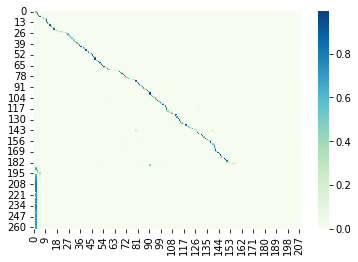

Saving Model..

Epoch: 2/50


Train:   0%|          | 0/298 [00:00<?, ?it/s]

<ipython-input-11-95cd4d6fa691>:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_mfcc = [torch.squeeze(train_transforms(torch.tensor(mfcc[np.newaxis, :]).permute(0, 2, 1)).permute(0, 2, 1), dim=0) for mfcc in batch_mfcc]
<ipython-input-11-95cd4d6fa691>:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_mfcc = [torch.squeeze(train_transforms(torch.tensor(mfcc[np.newaxis, :]).permute(0, 2, 1)).permute(0, 2, 1), dim=0) for mfcc in batch_mfcc]


Val:   0%|          | 0/29 [00:00<?, ?it/s]

Train, Loss: 0.1532, Perplexity: 1.1656 | Test, distance: 7.0465


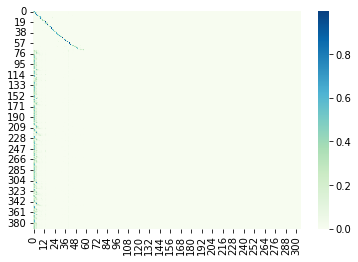


Epoch: 3/50


Train:   0%|          | 0/298 [00:00<?, ?it/s]

<ipython-input-11-95cd4d6fa691>:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_mfcc = [torch.squeeze(train_transforms(torch.tensor(mfcc[np.newaxis, :]).permute(0, 2, 1)).permute(0, 2, 1), dim=0) for mfcc in batch_mfcc]
<ipython-input-11-95cd4d6fa691>:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_mfcc = [torch.squeeze(train_transforms(torch.tensor(mfcc[np.newaxis, :]).permute(0, 2, 1)).permute(0, 2, 1), dim=0) for mfcc in batch_mfcc]


Val:   0%|          | 0/29 [00:00<?, ?it/s]

Train, Loss: 0.1538, Perplexity: 1.1664 | Test, distance: 7.0465


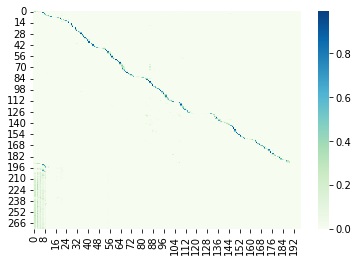


Epoch: 4/50


Train:   0%|          | 0/298 [00:00<?, ?it/s]

<ipython-input-11-95cd4d6fa691>:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_mfcc = [torch.squeeze(train_transforms(torch.tensor(mfcc[np.newaxis, :]).permute(0, 2, 1)).permute(0, 2, 1), dim=0) for mfcc in batch_mfcc]
<ipython-input-11-95cd4d6fa691>:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_mfcc = [torch.squeeze(train_transforms(torch.tensor(mfcc[np.newaxis, :]).permute(0, 2, 1)).permute(0, 2, 1), dim=0) for mfcc in batch_mfcc]


Val:   0%|          | 0/29 [00:00<?, ?it/s]

Train, Loss: 0.1541, Perplexity: 1.1667 | Test, distance: 7.0465


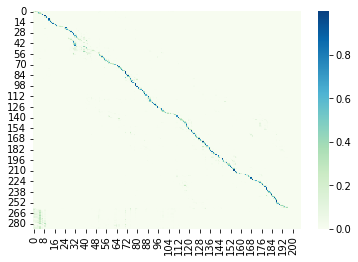


Epoch: 5/50


Train:   0%|          | 0/298 [00:00<?, ?it/s]

<ipython-input-11-95cd4d6fa691>:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_mfcc = [torch.squeeze(train_transforms(torch.tensor(mfcc[np.newaxis, :]).permute(0, 2, 1)).permute(0, 2, 1), dim=0) for mfcc in batch_mfcc]
<ipython-input-11-95cd4d6fa691>:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_mfcc = [torch.squeeze(train_transforms(torch.tensor(mfcc[np.newaxis, :]).permute(0, 2, 1)).permute(0, 2, 1), dim=0) for mfcc in batch_mfcc]


Val:   0%|          | 0/29 [00:00<?, ?it/s]

Train, Loss: 0.1544, Perplexity: 1.1671 | Test, distance: 7.0465


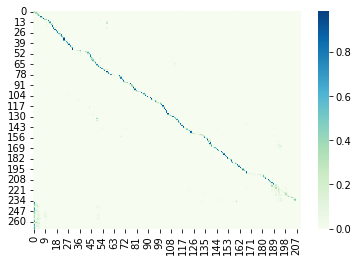


Epoch: 6/50


Train:   0%|          | 0/298 [00:00<?, ?it/s]

<ipython-input-11-95cd4d6fa691>:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_mfcc = [torch.squeeze(train_transforms(torch.tensor(mfcc[np.newaxis, :]).permute(0, 2, 1)).permute(0, 2, 1), dim=0) for mfcc in batch_mfcc]
<ipython-input-11-95cd4d6fa691>:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_mfcc = [torch.squeeze(train_transforms(torch.tensor(mfcc[np.newaxis, :]).permute(0, 2, 1)).permute(0, 2, 1), dim=0) for mfcc in batch_mfcc]


Val:   0%|          | 0/29 [00:00<?, ?it/s]

Train, Loss: 0.1923, Perplexity: 1.2122 | Test, distance: 7.0465


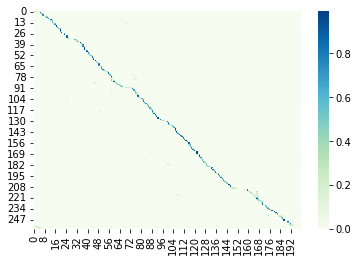


Epoch: 7/50


Train:   0%|          | 0/298 [00:00<?, ?it/s]

<ipython-input-11-95cd4d6fa691>:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_mfcc = [torch.squeeze(train_transforms(torch.tensor(mfcc[np.newaxis, :]).permute(0, 2, 1)).permute(0, 2, 1), dim=0) for mfcc in batch_mfcc]
<ipython-input-11-95cd4d6fa691>:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_mfcc = [torch.squeeze(train_transforms(torch.tensor(mfcc[np.newaxis, :]).permute(0, 2, 1)).permute(0, 2, 1), dim=0) for mfcc in batch_mfcc]


KeyboardInterrupt: ignored

In [ ]:
best_lev_dist = float("inf")
# tf_rate = 0.9

for epoch in range(0, config['epochs']):
    print("\nEpoch: {}/{}".format(epoch+1, config['epochs']))
    if epoch % 5 == 0 and epoch != 0:
      tf_rate = tf_rate * 0.9

    # Call train and validate 
    train_loss, train_perplexity, attention_plot = train(
        model=model, 
        dataloader=train_loader, 
        criterion=criterion, 
        optimizer=optimizer, 
        teacher_forcing_rate=tf_rate
    )
    val_lev_dist = validate(
        model=model, 
        dataloader=val_loader
    )
    
    # Print your metrics
    print(f"Train, Loss: {train_loss:.4f}, Perplexity: {train_perplexity:.4f} | Test, distance: {val_lev_dist:.4f}")
    
    # Plot Attention
    plot_attention(attention_plot)

    # Log metrics to Wandb
    scheduler.step(val_lev_dist)
    # tf_rate = tf_scheduler.step(val_lev_dist)
    
    # Optional: Scheduler Step / Teacher Force Schedule Step
    if val_lev_dist < best_lev_dist:
        # Save your model checkpoint here
        best_lev_dist = val_lev_dist
        torch.save({
            'model_state_dict':model.state_dict(),
            'optimizer_state_dict':optimizer.state_dict(),
            'val_dist': val_lev_dist, 
            'epoch': epoch,
            'scheduler_state_dict': scheduler.state_dict(),
            'tf_rate': tf_rate
          }, './checkpoint.pth'
        )
        print("Saving Model..")
        best_lev_dist = val_lev_dist
        wandb.save('checkpoint.pth')
    
    wandb.log({
        "train loss": train_loss,
        "train perplexity": train_perplexity,
        "validation distance": val_lev_dist, 
        "lr": optimizer.param_groups[0]['lr'],
        'tf_rate': tf_rate
    })

run.finish()

# Testing

In [ ]:
# !ls -l

total 2816392
-rw-r--r-- 1 root root 2238770789 Dec  4 07:27 11-785-f22-hw4p2.zip
-rw-r--r-- 1 root root  644888665 Dec  4 19:29 checkpoint.pth
drwxr-xr-x 3 root root       4096 Dec  4 07:27 data
drwx------ 6 root root       4096 Dec  4 19:49 drive
drwxr-xr-x 1 root root       4096 Dec  1 20:08 sample_data
-rw-r--r-- 1 root root     297527 Dec  4 19:44 submission.csv
drwxr-xr-x 4 root root       4096 Dec  4 10:07 wandb


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
torch.cuda.empty_cache()
gc.collect()

2630

In [ ]:
!cp /content/checkpoint_v5.pth /content/drive/MyDrive/hw4_p2_checkpoint_v5.pth

In [ ]:
# Optional: Load your best model Checkpoint here
checkpoint = torch.load("./checkpoint_v5.pth", map_location=DEVICE)
# model = LAS(
#     input_size=15, 
#     encoder_hidden_size=256, 
#     vocab_size=len(VOCAB), 
#     embed_size=256,
#     decoder_hidden_size=512, 
#     decoder_output_size=128,
#     projection_size=128
# )
# model = model.to(DEVICE)
model = LAS(
    input_size=15, 
    encoder_hidden_size=512, 
    vocab_size=len(VOCAB), 
    embed_size=256,
    decoder_hidden_size=1024, 
    decoder_output_size=128,
    projection_size=128
)

model = model.to(DEVICE)
model.load_state_dict(checkpoint["model_state_dict"], strict=False)
# optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
# scheduler.load_state_dict(checkpoint["scheduler_state_dict"])
tf_rate = checkpoint["tf_rate"]

In [ ]:
def test(model, dataloader):
    model.eval()
    res = []
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc="Test")
    for i, (x, lx) in enumerate(dataloader):
        x, lx = x.to(DEVICE), lx
        with torch.inference_mode():
            predictions, _ = model(x, lx, y=None)
        
        greedy_predictions = torch.argmax(predictions, dim=-1)
        greedy_predictions= greedy_predictions.cpu().detach().tolist()
        # print(greedy_predictions.cpu().detach().tolist())
        preds = ["".join(indices_to_chars(pred_indices, VOCAB)) for pred_indices in greedy_predictions]
        res.extend(preds)
        
        batch_bar.update()
        
        del x, lx
        torch.cuda.empty_cache()

    batch_bar.close()
    return res


In [ ]:
torch.cuda.empty_cache()
predictions = test(model, test_loader)

import pandas as pd

df = pd.read_csv('./data/hw4p2/test-clean/transcript/random_submission.csv')
df.label = predictions

df = df.rename(columns={"index": "id"})

df.to_csv('submission.csv', index = False)

Test:   0%|          | 0/28 [00:00<?, ?it/s]

In [ ]:
!kaggle competitions submit -c 11-785-f22-hw4p2 -f submission.csv -m "try six"

100% 289k/289k [00:03<00:00, 92.2kB/s]
Successfully submitted to Attention-Based Speech Recognition